In [90]:
import pandas as pd
import numpy as np
import os
from utils import *
from modules_importation import *

In [80]:
trade_uni = get_trade_uni()
fea_lst = ["close", "close_BTC", "high", "low", "open", "quote_volume", "taker_base_volume", "taker_quote_volume",
            "trades", "volume"]
freq = "1440min"
historical_data = get_historical_data(freq, fea_lst)

2024-04-11 10:52:29 1440min close data loaded
2024-04-11 10:52:29 1440min close_BTC data loaded
2024-04-11 10:52:29 1440min high data loaded
2024-04-11 10:52:29 1440min low data loaded
2024-04-11 10:52:29 1440min open data loaded
2024-04-11 10:52:29 1440min quote_volume data loaded
2024-04-11 10:52:29 1440min taker_base_volume data loaded
2024-04-11 10:52:29 1440min taker_quote_volume data loaded
2024-04-11 10:52:29 1440min trades data loaded
2024-04-11 10:52:29 1440min volume data loaded


In [98]:
factor_attribute_dict = {
        "factor_er_ratio": {
            "exec_mode": "longshort",
            "params": "15_3_0.5"},
        "factor_quantile": {
            "exec_mode": "longshort",
            "params": "5_5_0.7"},
        "factor_quantile_high_threshold": {
            "exec_mode": "longshort",
            "params": "8_3_1.3"},
        "factor_er_ratio_high_threshold": {
            "exec_mode": "longshort",
            "params": "15_2_1.2"}
    }
factor_file_dict = {}
for factor_name in factor_attribute_dict.keys():
    factor_file_dict[factor_name] = {}
    exec_mode = factor_attribute_dict[factor_name]["exec_mode"]
    factor_file_dict[factor_name]["pos"] = pd.read_csv(
        os.path.join(PROJECT_PATH, "optimization", exec_mode, factor_name, "pos.csv"), index_col=0)
    factor_file_dict[factor_name]["basecode_return"] = pd.read_csv(
        os.path.join(PROJECT_PATH, "optimization", exec_mode, factor_name, "basecode_return.csv"), index_col=0)
    factor_file_dict[factor_name]["pnl"] = pd.read_csv(
        os.path.join(PROJECT_PATH, "optimization", exec_mode, factor_name, "pnl.csv"), index_col=0)

factor_corr_list = ["factor_er_ratio", "factor_quantile", "factor_quantile_high_threshold", "factor_er_ratio_high_threshold"]

In [99]:
pnl_list = []
out = 0
for key in factor_file_dict.keys():
    pnl = factor_file_dict[key]["pnl"]
    if not out:
        pnl = pnl.loc[pnl.index <= "2021-12-31"]
    pnl_list.append(pnl)

res = pd.concat(pnl_list, axis=1)
res.columns = list(factor_file_dict.keys())
res = res.diff()
corr_matrix = res.corr(method='pearson')
# Set all values in the upper triangle to 0 excluding diagnal elements
for i in range(corr_matrix.shape[0]):
    for j in range(i, corr_matrix.shape[1]):
        corr_matrix.iloc[i, j] = 0
# create a function to apply to the dataframe for shading
def shade_over_0_3(df_values):
    threshold = 0.4
    color = 'background-color: red' if df_values > threshold else ''
    return color
# apply the function to the dataframe using style method
styled_df = corr_matrix.style.applymap(shade_over_0_3)
# show the styled dataframe
styled_df

,factor_er_ratio,factor_quantile,factor_quantile_high_threshold,factor_er_ratio_high_threshold
factor_er_ratio,0.000000,0.000000,0.000000,0.000000
factor_quantile,0.085242,0.000000,0.000000,0.000000
factor_quantile_high_threshold,0.131168,0.102527,0.000000,0.000000
factor_er_ratio_high_threshold,0.321158,-0.031694,0.024897,0.000000


In [100]:
# get pair-name of factors with correlation over 0.3 within the range of corr matrix
threshold = 0.4
mask = corr_matrix > threshold 
result = [(i+' & '+col+' | '+str(round(corr_matrix.loc[i, col], 2))) for i in corr_matrix.index for col in corr_matrix.columns if mask.loc[i, col]]
res = pd.DataFrame(np.full((len(result), 3), np.nan), columns = ['factor1', 'factor2', 'corr'])
for i in range(len(result)):
    res.iloc[i, 0] = result[i].split('|')[0].split('&')[0].strip()                  
    res.iloc[i, 1] = result[i].split('|')[0].split('&')[1].strip()
    res.iloc[i, 2] = result[i].split('|')[1].strip()
res

,factor1,factor2,corr


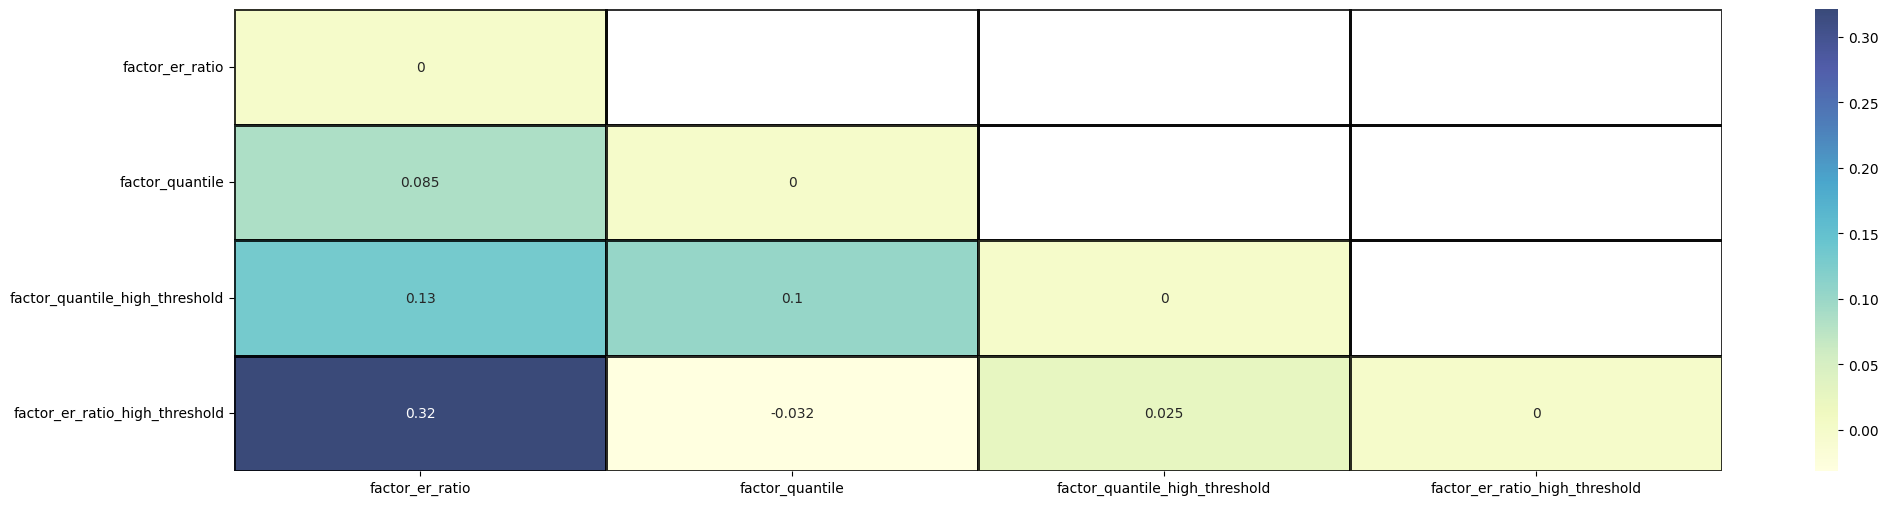

In [101]:
plt.subplots(figsize = (24, 6))     # 24 ,6 
# 消除斜对角线颜色重复的色块
arr = np.zeros_like(corr_matrix)       # 全0矩阵
arr[np.tril_indices_from(arr)] = 1
mask = np.full(corr_matrix.shape, np.nan)
mask[arr == 1] = 0
mask[arr == 0] = 1

sns.heatmap(corr_matrix, 
            cmap="YlGnBu",      # 设置热力图颜色
            alpha=0.8,  
            annot=True,         # 显示相关系数数据
            linewidths=1,       # 设置每个单元格的距离
            linecolor='black',  # 设置间距线的颜色
            cbar=True,
            square = False,
            mask=mask
            )
plt.show()

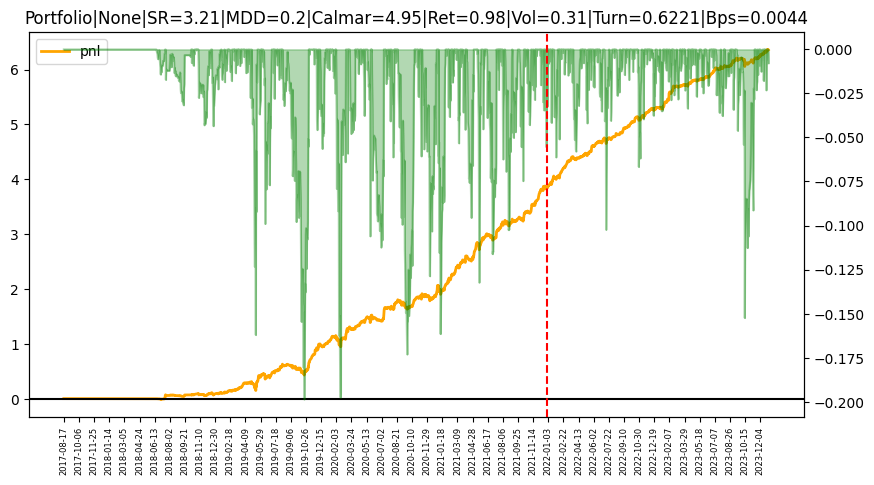

In [102]:
# Portfolio
factor_portfolio_list = ["factor_er_ratio", "factor_quantile", "factor_quantile_high_threshold", "factor_er_ratio_high_threshold"]    # combo factor
# factor_portfolio_list = ["factor_er_ratio", "factor_quantile"]    # combo factor
factor_num = len(factor_portfolio_list)
pos = pd.DataFrame()
pos_lst = []
for key in factor_file_dict.keys():
    pos_lst.append(factor_file_dict[key]["pos"])
weight_array = [1/factor_num] * factor_num
for factor_pos, weight in zip(pos_lst, weight_array):
    weighted_pos = factor_pos * weight
    pos = pos.add(weighted_pos, fill_value=0)
ret = np.log(historical_data["close"]) - np.log(historical_data["close"].shift(1))
coef_vol = adj_vol_coef(ret, STD_WINDOW, TARGET_VOL)
volatility_adjust = False
basecode_return = pos * ret
plot_pnl_general(basecode_return, pos, symbol="Portfolio", description="Portfolio")